In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [231]:
def get_event_times(row):
    start_queue1 = row["tm_arrival_queue1"]
    tm_queue1 = row["tm_start_service1"] - start_queue1
    
    start_service1 = row["tm_start_service1"]
    tm_service1 = row["tm_end_service1"] - start_service1
    
    start_queue2 = row["tm_arrival_queue2"]
    tm_queue2 = row["tm_start_service2"] - start_queue2
    
    start_service2 = row["tm_start_service2"]
    tm_service2 = row["tm_end_service2"] - start_service2
    
    sequencia = [
        (start_queue1, tm_queue1), 
        (start_service1, tm_service1), 
        (start_queue2, tm_queue2),
        (start_service2, tm_service2)
    ]
    cores = ('tab:orange', 'tab:green', 'tab:red', 'tab:blue')
    
    return sequencia, cores

In [232]:
def resumo(arquivo):
    events = pd.read_csv(arquivo, index_col=0)
    
    # Horizontal bar plot with gaps
    fig, ax = plt.subplots(figsize=(15, 4))

    for i, idx in enumerate(events.index):
        seq, cores = get_event_times(events.loc[idx])    
        ax.broken_barh(seq, (i+0.75, 0.5), facecolors=cores)

    # ax.set_ylim(5, 35)
    # ax.set_xlim(0, 200)
    ax.set_xlabel('seconds since start')
    # ax.set_yticks([15, 25], labels=['Bill', 'Jim'])     # Modify y-axis tick labels
    ax.grid(True)                                       # Make grid lines visible


    legend = ('queue1', 'service1', 'queue2', 'service2')

    leg1 = mlines.Line2D([], [], color=cores[0], marker='s', ls='', label=legend[0])
    leg2 = mlines.Line2D([], [], color=cores[1], marker='s', ls='', label=legend[1])
    leg3 = mlines.Line2D([], [], color=cores[2], marker='s', ls='', label=legend[2])
    leg4 = mlines.Line2D([], [], color=cores[3], marker='s', ls='', label=legend[3])

    plt.legend(handles=[leg1, leg2, leg3, leg4], loc="upper left")

    plt.show()

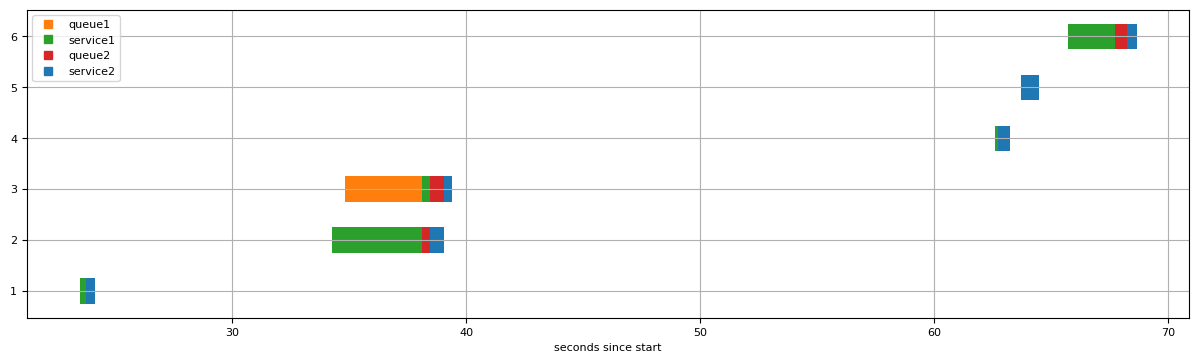

In [257]:
resumo("teste_retry.csv")

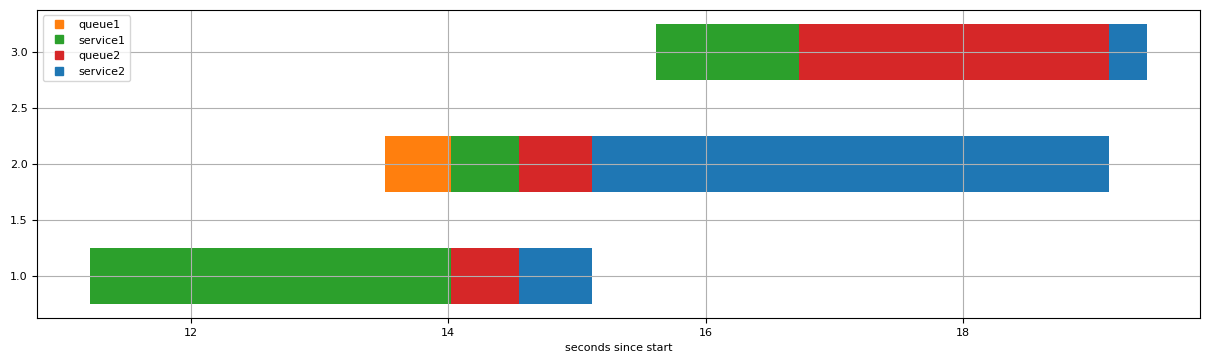

In [248]:
resumo("teste_prioridade.csv")

In [236]:
def get_statistics(row):
    start_queue1 = row["tm_arrival_queue1"]
    tm_queue1 = row["tm_start_service1"] - start_queue1
    
    start_service1 = row["tm_start_service1"]
    tm_service1 = row["tm_end_service1"] - start_service1
    
    start_queue2 = row["tm_arrival_queue2"]
    tm_queue2 = row["tm_end_service2"] - row["tm_service2"] - start_queue2
    
    tm_service2 = row["tm_service2"]
    
    return pd.Series({"tm_queue1": tm_queue1, "tm_service1": tm_service1, "tm_queue2": tm_queue2, "tm_service2": tm_service2})

In [237]:
events = pd.read_csv("teste_longo.csv", index_col=0)

In [238]:
statistics = events.apply(get_statistics, axis=1)

In [239]:
chunk_size = 1000
lim_superior = [chunk.mean() + 2 * chunk.std() for chunk in np.array_split(statistics["tm_queue1"], len(statistics)/chunk_size)]
lim_superior = pd.Series(lim_superior, index=range(0, len(lim_superior) * chunk_size, chunk_size))

<AxesSubplot: xlabel='identifier'>

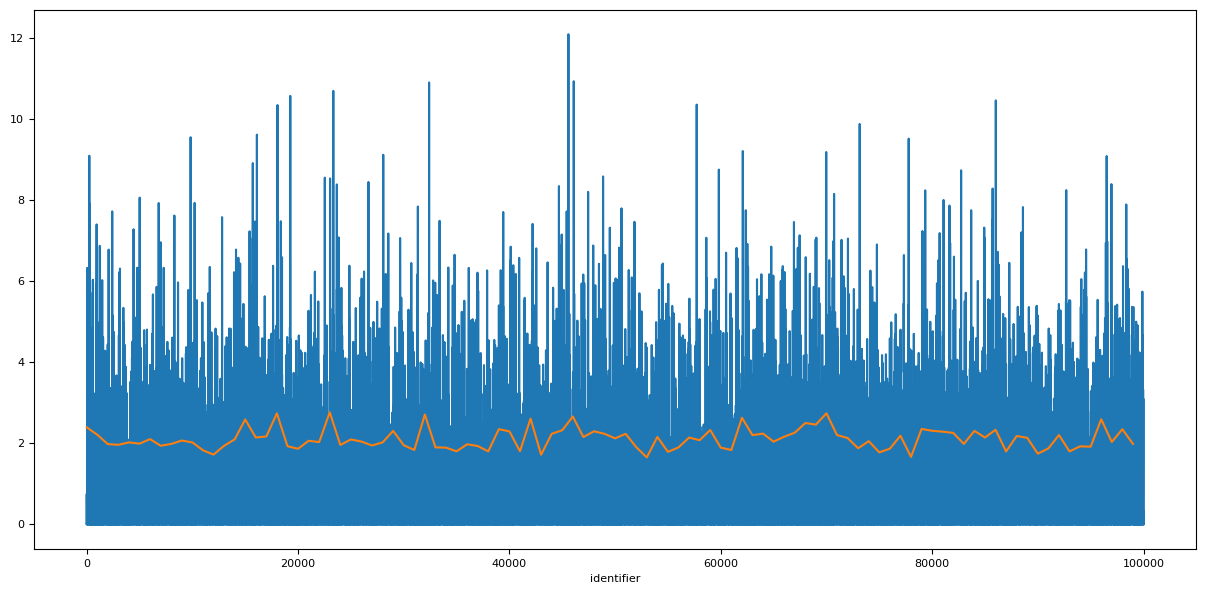

In [240]:
statistics["tm_queue1"].plot(figsize=(15,7))
lim_superior.plot(figsize=(15,7))

<AxesSubplot: xlabel='identifier'>

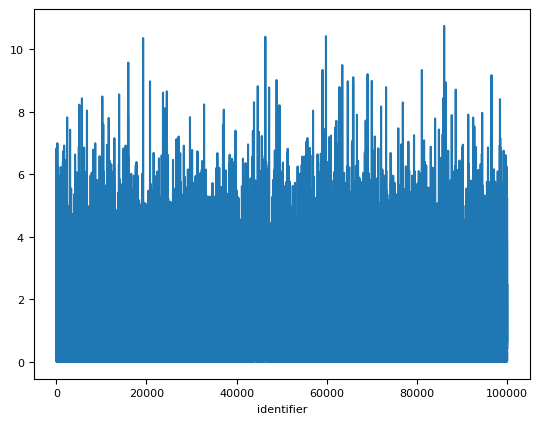

In [241]:
statistics["tm_service1"].plot()

<AxesSubplot: xlabel='identifier'>

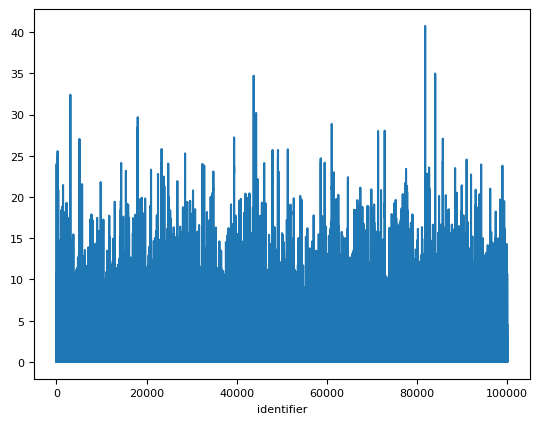

In [242]:
statistics["tm_queue2"].plot()

<AxesSubplot: xlabel='identifier'>

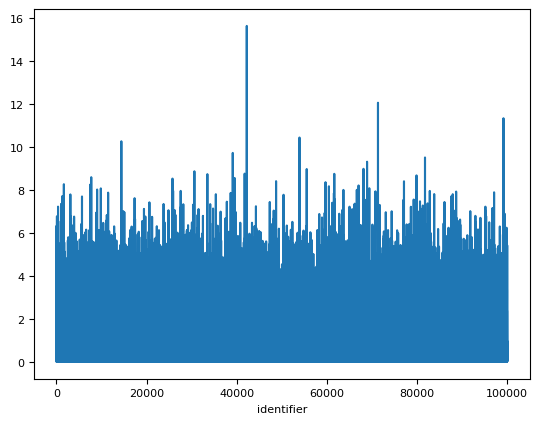

In [243]:
statistics["tm_service2"].plot()